In [117]:
from matplotlib import pyplot as plt
from selenium import webdriver
import time
import cv2
import glob
import os
import numpy as np

In [65]:
def sift_find_matches(img1, img2):    
    sift = cv2.xfeatures2d.SIFT_create()
    # keypoints e descritores
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    # FLANN
#     flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    try:
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des1, des2, k=2)
    except Exception as e:
        return 0, 0, None
    
    matches_mask = [[0,0]] * len(matches)
    good_matches = 0
    
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7 * n.distance:
            matches_mask[i] = [1, 0]
            good_matches += 1
    
    draw_params = dict(matchColor=(0, 255, 0), singlePointColor=(255, 0, 0), matchesMask=matches_mask, flags=0)
    img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)
    
    return good_matches, len(matches), img3

In [11]:
def take_screenshot(url, path):
    driver = webdriver.Chrome('./chromedriver')
    driver.get(url)
    time.sleep(5)
    driver.execute_script('''
    var anchors = document.getElementsByTagName('a');
    var l = anchors.length;
    for (var i = 0; i < l; i++) {
        var children = anchors[i].children;
        var cl = children.length;
        var clean = true;
        for (var j = 0; j < cl; j++) {
            clean = clean && !(children[j] instanceof HTMLImageElement);
        }
        if (clean) anchors[i].innerHTML = '';
    }
    var buttons = document.getElementsByTagName('button');
    var labels = document.getElementsByTagName('label');
    var lb = buttons.length;
    var ll = labels.length;
    for (var i = 0; i < lb; i++) buttons[i].innerHTML = '';
    for (var i = 0; i < ll; i++) labels[i].innerHTML = '';
    ''')
    driver.save_screenshot(path)
    driver.quit()

In [172]:
# classifier

def sift_classifier(url=None, screenshot_path=None, img_screenshot=None, dataset_dir='./dataset_auto'):
    matches = dict()
    best_descriptors = dict()
    qty_images = dict()
    elected = None
    max_matches = -1
    
    if url and screenshot_path:
        take_screenshot(url, screenshot_path)
        img_screenshot = cv2.imread(screenshot_path)
        h, _, _ = img_screenshot.shape
        img_screenshot = img_screenshot[:int(h/2), :]

    for img_path in glob.glob(dataset_dir + '/*'):
        label = img_path.split('/')[-1].split('_')[0]
        img_dataset = cv2.imread(img_path)
        if not qty_images.get(label):
            qty_images[label] = len(glob.glob(dataset_dir + '/' + label + '*'))
            best_descriptors[label] = best_descriptors.get(label, [0, None])
        good_matches, _, matches_img = sift_find_matches(img_dataset, img_screenshot)
        if good_matches > best_descriptors[label][0]:
            best_descriptors[label] = [good_matches, matches_img]
        matches[label] = matches.get(label, 0)  + float(good_matches) / qty_images[label]
        if max_matches < matches[label]:
            elected = label
            max_matches = matches[label]

    return elected, max_matches, best_descriptors[elected][-1], matches

In [147]:
def extract_visual_identity(img, directory, label, show_images=False):
    h, w, _ = img.shape
    img = img[:int(h/2), :]
    img_original = img.copy()
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    _, tresh = cv2.threshold(img_gray, 127, 255, 0)
    img_binary, contours, hierarchy = cv2.findContours(tresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    useful_contours = []
    # usa apenas contornos estao no penultimo nivel da arvore
    for idx, node in enumerate(hierarchy[0]):
        # para ser folha: nao tem filho
        # para ser penultimo nivel: nao eh avo
        child_index = node[-2]
        if child_index != -1:
            child = hierarchy[0][child_index]
            # para ser penultimo nivel, filho tem que ser folha
            if child[-2] == -1:
                useful_contours.append(contours[idx])
    
    img_contourned = cv2.drawContours(img, useful_contours, -1, (0, 255, 0), 3)
    if show_images:
        plt.figure()
        plt.imshow(img_contourned[...,::-1])
    
    erosion_kernel = np.ones((5, 5), np.uint8) * 255

    for i, c in enumerate(useful_contours):
        rect = cv2.boundingRect(c)
        x, y, w, h = rect
        cropped = img_binary[y: y + h, x: x + w]
        erosion = cv2.erode(cropped, erosion_kernel, iterations=1)
        black_pixels = len(erosion[erosion == 0])
        total_pixels = len(erosion[erosion > -1])
        
        if show_images and i < 10:
            plt.figure()
            plt.imshow(cropped[...,::-1])
            plt.figure()
            plt.imshow(erosion[...,::-1])
            
        if 0.9 > float(black_pixels) / total_pixels > 0.1:
            to_save = img_original[y: y + h, x: x + w]
            if to_save.shape != img.shape:
                cv2.imwrite('{}/{}_{}.png'.format(directory, label, int(time.time())), img_original[y: y + h, x: x + w])

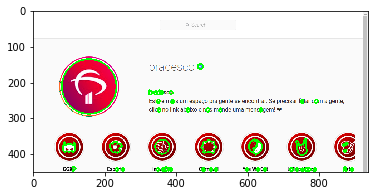

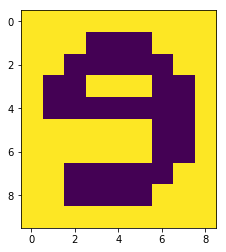

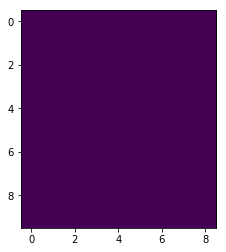

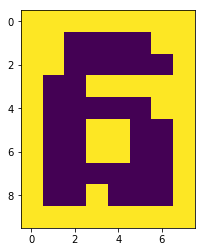

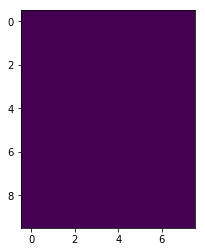

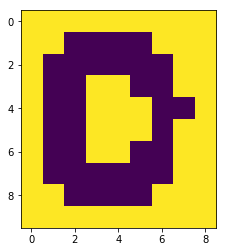

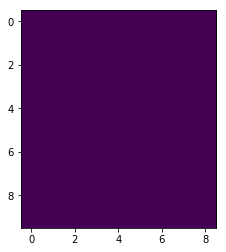

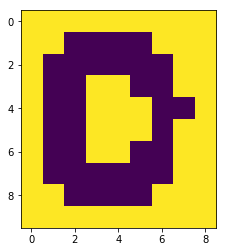

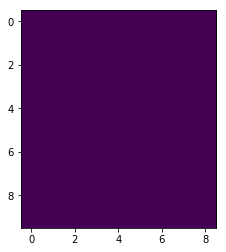

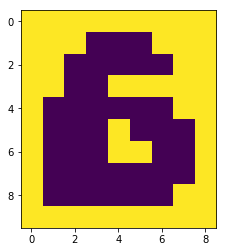

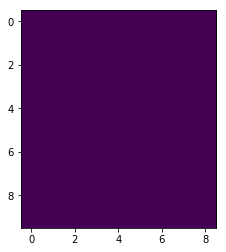

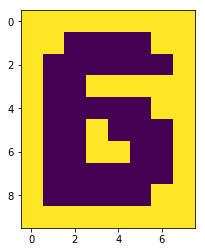

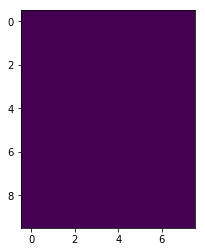

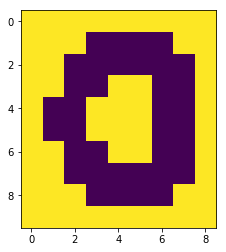

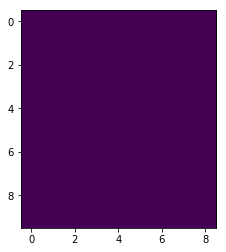

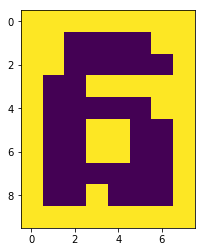

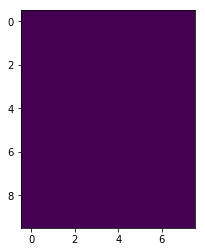

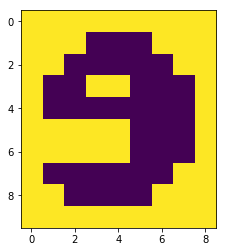

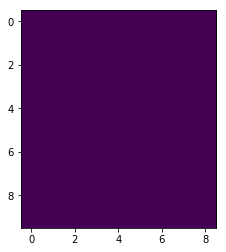

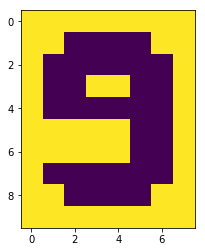

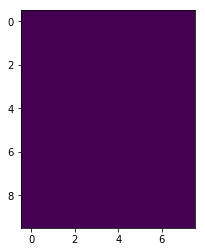

In [148]:
# example visual id extraction
take_screenshot('https://instagram.com.br/bradesco', './bradesco_demo.png')
extract_visual_identity(cv2.imread('./bradesco_demo.png'), './', 'bradesco', show_images=True)

In [156]:
def sift_feature_engineering(images_dir, label, epsilon=0.03):
    compared = dict()
    matches = dict()
    for f1 in glob.glob('{}/{}*.png'.format(images_dir, label)):
        compared[(f1, f1)] = True
        matches[f1] = matches.get(f1, 0)
        for f2 in glob.glob('{}/{}*.png'.format(images_dir, label)):
            matches[f2] = matches.get(f2, 0)
            if not compared.get((f1, f2)):
                good_matches, all_matches, _ = sift_find_matches(cv2.imread(f1), cv2.imread(f2))
                matches[f1] += good_matches
                matches[f2] += good_matches
                compared[(f1, f2)] = compared[(f2, f1)] = True
    max_matches = -1
    for _, m in matches.items():
        max_matches = max(max_matches, m)
    print(matches)
    for f, m in matches.items():
        try:
            rel = float(m) / max_matches
        except ZeroDivisionError:
            rel = 0
        if rel <= epsilon:
            os.remove(f)

In [154]:
def auto_mount_dataset(urls, labels, directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    for i, url in enumerate(urls):
        screenshot_path = '{}/{}_screenshots_{}.png'.format(directory, labels[i], i)
        take_screenshot(url, screenshot_path)
        screenshot_img = cv2.imread(screenshot_path)
        h, _, _ = screenshot_img.shape
        cv2.imwrite(screenshot_path, screenshot_img[:int(h/2), :])
        extract_visual_identity(screenshot_img, directory, labels[i])
    for l in set(labels):
        sift_feature_engineering(directory, l)
        

In [158]:
# example mounting dataset
auto_mount_dataset(['htpps://itau.com.br', 'https://twitter.com.br/itau', 'https://instagram.com.br/itau',
                   'https://bradesco.com.br', 'https://twitter.com.br/bradesco', 'https://instagram.com/bradesco',
                   'https://nubank.com.br', 'https://twitter.com.br/nubank', 'https://instagram.com/nubank',
                   'https://original.com.br', 'https://twitter.com.br/bancooriginal', 'https://instagram.com/bancooriginal',
                   'https://www.bancointer.com.br/', 'https://twitter.com.br/bancointer', 'https://www.instagram.com/bancointer/'], 
                   ['itau', 'itau', 'itau', 'bradesco', 'bradesco', 'bradesco', 'nubank', 'nubank', 'nubank',
                   'bancooriginal', 'bancooriginal', 'bancooriginal', 'bancointer', 'bancointer', 'bancointer'], 
                   './dataset_auto')

{'./dataset_auto/itau_1543326940.png': 15, './dataset_auto/itau_screenshots_2.png': 72, './dataset_auto/itau_1543326928.png': 14, './dataset_auto/itau_screenshots_0.png': 0, './dataset_auto/itau_screenshots_1.png': 97}
{'./dataset_auto/bancointer_screenshots_14.png': 93, './dataset_auto/bancointer_1543327075.png': 14, './dataset_auto/bancointer_screenshots_12.png': 62, './dataset_auto/bancointer_1543327062.png': 40, './dataset_auto/bancointer_screenshots_13.png': 80, './dataset_auto/bancointer_1543327085.png': 83}
{'./dataset_auto/bancooriginal_1543327051.png': 2, './dataset_auto/bancooriginal_screenshots_10.png': 215, './dataset_auto/bancooriginal_1543327040.png': 42, './dataset_auto/bancooriginal_screenshots_9.png': 176, './dataset_auto/bancooriginal_screenshots_11.png': 46, './dataset_auto/bancooriginal_1543327027.png': 1}
{'./dataset_auto/bradesco_1543326980.png': 59, './dataset_auto/bradesco_screenshots_5.png': 94, './dataset_auto/bradesco_1543326954.png': 1, './dataset_auto/brade

good matches: 43
total matches: 768


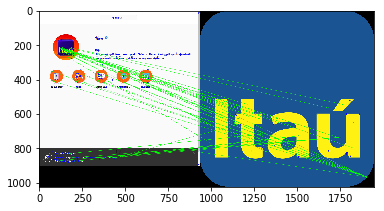

In [89]:
# example
screenshot_img = cv2.imread('./screenshots/itau_instagram.png')
dataset_img = cv2.imread('./dataset_hand/itau_1.png')
good_matches, matches_size, img_match = sift_find_matches(screenshot_img, dataset_img)
print('good matches:', good_matches)
print('total matches:', matches_size)
plt.imshow(img_match[...,::-1])

In [21]:
# example
take_screenshot('https://twitter.com.br/itau', './screenshots/itau_twitter.png')
take_screenshot('https://instagram.com.br/itau', './screenshots/itau_instagram.png')

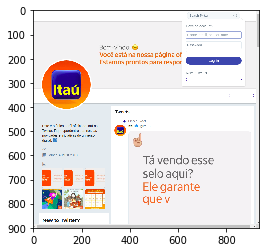

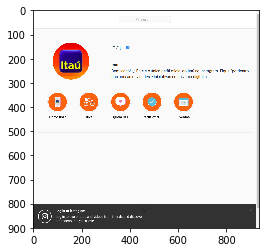

In [62]:
# example

img_twitter = cv2.imread('./screenshots/itau_twitter.png')
img_instagram = cv2.imread('./screenshots/itau_instagram.png')

plt.figure()
plt.imshow(img_twitter[...,::-1])   # RGB -> BGR
plt.figure()
plt.imshow(img_instagram[...,::-1])

elected itau
matches average 45.714285714285715 matches per image
all matches informations (matches per image) {'itau': 45.714285714285715, 'bradesco': 26.2, 'bancointer': 19.0, 'bancooriginal': 14.0, 'nubank': 13.0}


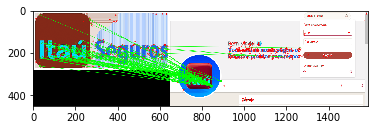

In [162]:
# example 1
elected, qty_matches, img_matches, matches_dict = sift_classifier('https://twitter.com.br/itau', 
                                                                  './screenshots/itau_test1.png', 
                                                                  dataset_dir='./dataset_hand/')
print('elected', elected)
print('matches average', qty_matches, 'matches per image')
print('all matches informations (matches per image)', matches_dict)
plt.figure()
plt.imshow(img_matches)

elected nubank
matches average 31.5 matches per image
all matches informations (matches per image) {'itau': 9.571428571428571, 'bradesco': 16.0, 'bancointer': 13.25, 'bancooriginal': 6.333333333333334, 'nubank': 31.5}


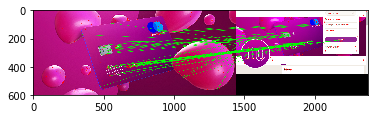

In [163]:
# example 2
elected, qty_matches, img_matches, matches_dict = sift_classifier('https://twitter.com.br/nubank', 
                                                                  './screenshots/nubank_test1.png', 
                                                                  dataset_dir='./dataset_hand/')
print('elected', elected)
print('matches average', qty_matches, 'matches per image')
print('all matches informations (matches per image)', matches_dict)
plt.figure()
plt.imshow(img_matches)

elected bradesco
matches average 18.6 matches per image
all matches informations (matches per image) {'itau': 3.857142857142857, 'bradesco': 18.6, 'bancointer': 3.0, 'bancooriginal': 5.0, 'nubank': 10.25}


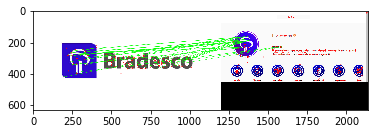

In [104]:
# example 3
elected, qty_matches, img_matches, matches_dict = sift_classifier('https://www.instagram.com/bradesco/', 
                                                                  './screenshots/bradesco_test1.png', 
                                                                  dataset_dir='./dataset_hand/')
print('elected', elected)
print('matches average', qty_matches, 'matches per image')
print('all matches informations (matches per image)', matches_dict)
plt.figure()
plt.imshow(img_matches)

elected bancooriginal
matches average 14.0 matches per image
all matches informations (matches per image) {'itau': 10.0, 'bradesco': 12.8, 'bancointer': 11.0, 'bancooriginal': 14.0, 'nubank': 10.75}


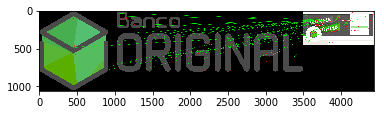

In [164]:
# example 4
elected, qty_matches, img_matches, matches_dict = sift_classifier('https://twitter.com/bancooriginal?lang=pt', 
                                                                  './screenshots/bancooriginal_test1.png', 
                                                                  dataset_dir='./dataset_hand/')
print('elected', elected)
print('matches average', qty_matches, 'matches per image')
print('all matches informations (matches per image)', matches_dict)
plt.figure()
plt.imshow(img_matches)

elected bradesco
matches average 4.0 matches per image
all matches informations (matches per image) {'itau': 2.0, 'bradesco': 4.0, 'bancointer': 2.25, 'bancooriginal': 1.3333333333333333, 'nubank': 2.75}


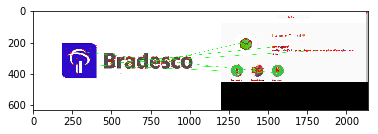

In [165]:
# example 5
elected, qty_matches, img_matches, matches_dict = sift_classifier('https://instagram.com/bancooriginal', 
                                                                  './screenshots/bancooriginal_test2.png', 
                                                                  dataset_dir='./dataset_hand/')
print('elected', elected)
print('matches average', qty_matches, 'matches per image')
print('all matches informations (matches per image)', matches_dict)
plt.figure()
plt.imshow(img_matches)

elected bancooriginal
matches average 33.333333333333336 matches per image
all matches informations (matches per image) {'itau': 11.142857142857142, 'bradesco': 12.000000000000002, 'bancointer': 5.5, 'bancooriginal': 33.333333333333336, 'nubank': 11.0}


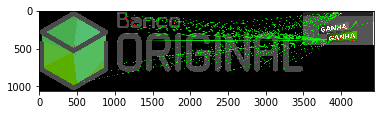

In [166]:
# example 6
elected, qty_matches, img_matches, matches_dict = sift_classifier('https://www.original.com.br/', 
                                                                  './screenshots/bancooriginal_test3.png', 
                                                                  dataset_dir='./dataset_hand/')
print('elected', elected)
print('matches average', qty_matches, 'matches per image')
print('all matches informations (matches per image)', matches_dict)
plt.figure()
plt.imshow(img_matches)  

elected nubank
matches average 12.75 matches per image
all matches informations (matches per image) {'itau': 2.4285714285714284, 'bradesco': 11.0, 'bancointer': 7.5, 'bancooriginal': 1.0, 'nubank': 12.75}


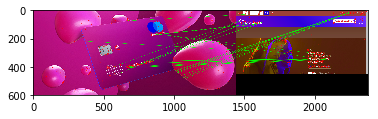

In [167]:
# example 6
elected, qty_matches, img_matches, matches_dict = sift_classifier('https://www.bradesco.com.br/', 
                                                                  './screenshots/bradesco_test3.png', 
                                                                  dataset_dir='./dataset_hand/')
print('elected', elected)
print('matches average', qty_matches, 'matches per image')
print('all matches informations (matches per image)', matches_dict)
plt.figure()
plt.imshow(img_matches)  

## Testes com o dataset gerado manualmente

In [177]:
labels_to_test = ['bradesco', 'itau', 'nubank', 'bancointer']
correct = 0
total = 0
for l in labels_to_test:
    for f in glob.glob('./phishing/{}*'.format(l)):
        elected, _, _, matches_dict = sift_classifier(img_screenshot=cv2.imread(f), dataset_dir='./dataset_hand')
        if elected != l:
            print(elected, '!=', l,'MISMATCH. scores:', matches_dict)
        else:
            correct += 1.
        total += 1.
print('Accuracy:', correct/total)

bradesco != itau MISMATCH. scores: {'itau': 13.0, 'bradesco': 22.6, 'bancointer': 7.75, 'bancooriginal': 1.3333333333333333, 'nubank': 3.0}
bancooriginal != itau MISMATCH. scores: {'itau': 16.428571428571427, 'bradesco': 10.2, 'bancointer': 15.5, 'bancooriginal': 19.0, 'nubank': 15.75}
bradesco != nubank MISMATCH. scores: {'itau': 3.2857142857142856, 'bradesco': 8.0, 'bancointer': 4.0, 'bancooriginal': 1.0, 'nubank': 6.5}
bradesco != nubank MISMATCH. scores: {'itau': 11.571428571428571, 'bradesco': 14.0, 'bancointer': 10.25, 'bancooriginal': 8.333333333333334, 'nubank': 13.5}
bradesco != bancointer MISMATCH. scores: {'itau': 6.571428571428571, 'bradesco': 10.0, 'bancointer': 8.25, 'bancooriginal': 2.0, 'nubank': 4.5}
Accuracy: 0.75


## Testes com o dataset gerado automaticamente

In [179]:
correct = 0
total = 0
for l in labels_to_test:
    for f in glob.glob('./phishing/{}*'.format(l)):
        elected, _, _, matches_dict = sift_classifier(img_screenshot=cv2.imread(f), dataset_dir='./dataset_auto')
        if elected != l:
            print(elected, '!=', l,'MISMATCH. scores:', matches_dict)
        else:
            correct += 1.
        total += 1.
print('Accuracy:', correct/total)

bancooriginal != itau MISMATCH. scores: {'bradesco': 14.0, 'nubank': 7.6000000000000005, 'bancointer': 10.166666666666666, 'itau': 12.75, 'bancooriginal': 18.5}
bancooriginal != nubank MISMATCH. scores: {'bradesco': 13.5, 'nubank': 3.8, 'bancointer': 6.666666666666666, 'itau': 8.25, 'bancooriginal': 14.75}
bradesco != nubank MISMATCH. scores: {'bradesco': 14.25, 'nubank': 11.600000000000001, 'bancointer': 11.666666666666666, 'itau': 8.25, 'bancooriginal': 7.0}
bradesco != nubank MISMATCH. scores: {'bradesco': 15.75, 'nubank': 5.8, 'bancointer': 8.166666666666668, 'itau': 8.25, 'bancooriginal': 12.25}
bradesco != nubank MISMATCH. scores: {'bradesco': 16.5, 'nubank': 5.4, 'bancointer': 8.833333333333334, 'itau': 4.75, 'bancooriginal': 11.5}
Accuracy: 0.75


## Testes com o dataset misto

In [180]:
correct = 0
total = 0
for l in labels_to_test:
    for f in glob.glob('./phishing/{}*'.format(l)):
        elected, _, _, matches_dict = sift_classifier(img_screenshot=cv2.imread(f), dataset_dir='./dataset_mixed')
        if elected != l:
            print(elected, '!=', l,'MISMATCH. scores:', matches_dict)
        else:
            correct += 1.
        total += 1.
print('Accuracy:', correct/total)

bradesco != itau MISMATCH. scores: {'itau': 18.454545454545457, 'bradesco': 21.0, 'bancointer': 10.599999999999998, 'bancooriginal': 7.857142857142858, 'nubank': 4.555555555555555}
bancooriginal != itau MISMATCH. scores: {'itau': 15.09090909090909, 'bradesco': 11.88888888888889, 'bancointer': 12.299999999999999, 'bancooriginal': 18.714285714285715, 'nubank': 11.222222222222223}
bradesco != nubank MISMATCH. scores: {'itau': 5.09090909090909, 'bradesco': 10.444444444444445, 'bancointer': 5.6, 'bancooriginal': 8.857142857142858, 'nubank': 5.0}
bradesco != nubank MISMATCH. scores: {'itau': 10.363636363636363, 'bradesco': 14.777777777777777, 'bancointer': 9.0, 'bancooriginal': 10.571428571428571, 'nubank': 9.222222222222221}
bradesco != nubank MISMATCH. scores: {'itau': 5.545454545454545, 'bradesco': 13.88888888888889, 'bancointer': 7.3, 'bancooriginal': 8.999999999999998, 'nubank': 9.222222222222221}
Accuracy: 0.75
